In [1]:
import numpy as np
import sklearn as skl
import pandas as pd
from sklearn import model_selection

from scipy.stats import norm

import os
my_path = os.path.abspath('figs_pos_full')
    
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
regularizer = 1
d = 2
T = 5
b = np.zeros(d)
burn_in_steps = 5
N_t = 0
observation_set = []

x_old = 0

a_t = 0
z_t_tilde = 0

# initializing weights
B = np.ones(d) * (1/regularizer) #np.diag( np.repeat(lambda_, d) )
#print(self.B.shape)

theta_t_m = np.zeros((T, burn_in_steps, d))
theta_t_m[0, (burn_in_steps-1), :] = np.random.normal(b, B**(1/2))

#self.B = np.identity(self.d) * self.regularizer #np.diag( np.repeat(lambda_, d) )
theta_t = np.zeros((T, d))
theta_t[0] = np.random.normal(b, B**(1/2))
#np.random.normal(self.theta_hat, (self.q_t)**(-1/2.0), size = self.d)

######################################################################################

# Logistic Function 
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def compute_a_n(x, n, born=0.64):
    if np.all(x > born):
        a_n = np.pi * (n+0.5) * np.exp(- ((n+0.5)**2) * (np.pi**2) * (x/2) )
    elif np.all(x <= born):
        a_n = np.pi * (n+0.5) * ( (2/(np.pi*x))**(3/2) ) * np.exp(- ((n+0.5)**2) * (2/x) )
#     else:
#         a_n=0
    return a_n

def compute_c_g(x, z, born=0.64):
    c_g = (np.pi/2) * np.cosh(z)
    if np.all(x > born):
        c_g *= np.exp(- ( (0.5* z**2) + (np.pi**2)/8 ) * x)
    else:
        c_g *= ( (2/(np.pi*x))**(3/2) ) * np.exp(-((z**2)*x/2) - (1/(2*x)))
    return c_g

def compute_X_from_g(x, z, born=0.64):
    if all(x > born):
        sample_X = np.random.exponential(scale= 1/(-0.5*z**2 + np.pi**2 / 8)) +born
        #print('sup, sample', sample_X)
    else:
        if z==0:
            z= 0.001
        sample_X = np.random.wald(np.abs(z)**(-1), 1, size=1)
        #print('inf, sample', sample_X)
    return sample_X

In [4]:
x = np.array([np.random.uniform(0,1,d)])
print(x)
print(theta_t[0])
z = x.dot(theta_t[0])
print(z)

[[0.31719086 0.08666292]]
[ 0.29145764 -0.04514362]
[0.08853542]


In [5]:
# Sn = np.zeros(10)
# for i in range(10):
#     an = compute_a_n(x,i)
#     print(an)
#     if i==0:
#         Sn[0] = (-1)**i * an
#     else:
#         Sn[i] = Sn[i-1] + (-1)**i * an
# print(Sn)

In [6]:
# print(compute_c_g(x, z))
# c_g = np.zeros(20)
# i=0
# for x in np.random.uniform(0,1, 20):
#     x = np.array([np.random.uniform(0,1)])
#     z = x.dot(theta_t[0])
#     c_g[i] = compute_c_g(x,z)
#     i+=1
# plt.plot(c_g)
# print(np.sum(c_g))
# print(compute_X_from_g(x,z))

In [7]:
# x = np.array([np.random.uniform(0,1, 2)])
# x_= x.reshape(-1, d)
# accept = False
# omega_vect = np.zeros(x_.shape[0])
# for i in range(x_.shape[0]):
#     z = x_[i].T.dot(theta_t[0])
#     print('x_i', x_[i])
#     ite=0

#     #while not accept:
#     # first step
#     sample = compute_X_from_g(x_[i], z)
#     #print('sample',sample)

#     #second step
#      # U ~ Unif(0, c_g_z)
#     u = np.random.uniform(low=0, high= compute_c_g(sample, z))
#     print('u',u)

#     # third step
#         #if (num % 2 == 0): #number is even 
#         #else: #number is odd 
#     Sn=0
#     for n in range(50):
#     #while 
#         a_n = compute_a_n(sample, n)
#         print('a_n', a_n)
#         Sn += (-1)**n * a_n
#         print('Sn',Sn, 'n', n)
#         if (u <= Sn and n%2 !=0):
#             print(sample/4)
#             break

In [8]:
#### new 
def PG_distribution(x_, theta_):
    # Y ~ PG(1, z) <=> Y = X/4 where X ~ J*(1, z/2)
    #if (num % 2 == 0): #number is even 
    #else: #number is odd 
    #####
    #from scipy.stats import norm
    
    ##########################################################
    ## a_n
    def compute_a_n(x, n, born=0.64):
        if np.all(abs(x) > born):
            a_n = np.pi * (n+0.5) * np.exp(- ((n+0.5)**2) * (np.pi**2) * (x/2) )
        elif np.all(abs(x) <= born):
            a_n = np.pi * (n+0.5) * ( (2/(np.pi*x))**(3/2) ) * np.exp(- ((n+0.5)**2) * (2/x) )
        return a_n
    
    ## pigauss: cdf of IG distribution
    def pigauss(mu, lamb, born=0.64):
        part1 = norm.cdf( np.sqrt(lamb/born) * ((born/mu) - 1.) )
        part2 = np.exp(2*lamb/mu) * norm.cdf(- np.sqrt(lamb/born) * ((born/mu) + 1.) )
        cdf = part1 + part2
        return cdf
    
    ## generate from IG
    def gen_IG(mu, c=1, born=0.64):
        #
        mu = abs(mu)
        #
        z = 1/mu # mu = 1/z
        if mu > born:
            E, E_prime = np.random.exponential(1, size=2)
            sampl = born / (1 + born*E)**2
            alpha = np.exp(-0.5 * sampl * z**2)
            u = np.random.uniform(0,1)
            while u > alpha:
                while pow(E, 2) > (2* E_prime/born):
                    E, E_prime = np.random.exponential(1, size=2)
                sampl = born / (1 + born*E)**2
                alpha = np.exp(-0.5 * sampl * z**2)
                u = np.random.uniform(0,1)
        else:
            y = np.random.normal(0,1)**2
            sampl = mu + 0.5 * (mu**2) * y - 0.5*mu* np.sqrt(4*mu*y + (mu*y)**2)
            u = np.random.uniform(0,1)
            if u > (mu/ (mu+sampl)):
                sampl = mu**2 / sampl
            while sampl > u:
                y = np.random.normal(0,1)**2
                sampl = mu + 0.5 * (mu**2) * y - 0.5*mu* np.sqrt(4*mu*y + (mu*y)**2)
                u = np.random.uniform(0,1)
                if u > (mu/ (mu+sampl)):
                    sampl = mu**2 / sampl
        return sampl
    
    #######################################################################
    
    x_ = x_.reshape(-1, d)

    #
    born = 0.64
    z = abs(x_.dot(theta_)) /2
    
    K = pow(np.pi, 2)/8 + pow(z,2)/2
    p = (np.pi / (2*K)) * np.exp(-K*born) # prob
    q = 2* np.exp(- abs(z)) * pigauss(mu= (1/z), lamb = 1.0) # prob

    # first step: begin
    cond = 0 #True
    ite=0
    while cond<100:
        U, V = np.random.uniform(0,1, size=2)
        
        # second step:begin
        if U < (p/(p+q)):
            # truncated exponential
            sample = born + np.random.exponential(scale=1)/K
        else:
            # truncated inverse gaussian
            mu = abs(1/z) # 1/ abs(z)
            
            # third step: begin
            if mu > born:
                
                sample = 1 / np.random.chisquare(1)
                while np.random.uniform(0,1) >= np.exp(-(sample * z**2 /2)):
                    sample = 1 / np.random.chisquare(1)
                
            else:
                #
                sample = gen_IG(mu, 1.0, born=0.64) # np.random.wald(mu, 1.0)
                while sample >= born:
                    sample = gen_IG(mu, 1.0, born=0.64) 
                
            #third step: end
        # second step: end
        n = 0
        S = compute_a_n(sample, n)
        Y = V * S
        #
        cond1 = 0 #True
        while cond1<10:
            n += 1
            if n%2 != 0: # n is odd
                S -= compute_a_n(sample, n)
                #
                if Y < S:
                    return sample/4 #omega_vect[i] = sample/4
                    
            else:
                S += compute_a_n(sample, n)
                cond1 +=1
                if Y > S:
                    #cond1 +=1
                    break
            # end if
        #end while
        ite +=1
        cond +=1
    #end while

In [9]:
theta_t[0].shape

(2,)

In [10]:
ome = PG_distribution(np.array(np.random.uniform(0,1, 2)), theta_t[0])
print(ome)

[0.19194449]


In [11]:
theta_t[0]

array([ 0.29145764, -0.04514362])

In [12]:
mu = 0.0
sigmasq = 1.0

N_samples = 1000
N=10
y = np.random.binomial(N, 0.5)

xs = np.random.uniform(-1,1, (N_samples,2)) # np.zeros(N_samples)
omegas = np.ones(N_samples)

# Now run the Gibbs sampler
for i in range(1, N_samples):
    # Sample omega given x, y from its PG conditional
    omegas[i] = PG_distribution(np.array(xs[i]), theta_t[0])
    #print(omegas[i])

    # Sample x given omega, y from its Gaussian conditional
    sigmasq_hat = 1./(1. / sigmasq + omegas[i])
    mu_hat = sigmasq_hat * (mu / sigmasq + (y - N / 2.))
    xs[i] = np.random.normal(mu_hat, np.sqrt(sigmasq_hat))
#print(xs)
#print('omega', omegas[i])

In [13]:
xs.shape

(1000, 2)

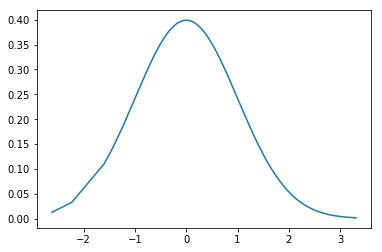

In [14]:
xs0 = np.sort(xs[:,0])
plt.plot(xs0, norm.pdf(xs0))

In [149]:
## True State Modelling
def fun_m_omega(x, V, kapa):
    # kapa: vector of regret_j - (1/2) for j=1,...,t
    # V: matrix d*d, the covariance matrix
    # m: vector dimension d, the mean
    # x: context
    x = x.reshape(-1, d)
    B_inv = np.identity(d) * regularizer
    
    m = V @ ( (x.T).dot(kapa) + B_inv.dot(b) )
    #print(m)
    return m


#######################

def fun_V_omega(x, omega_vec):
    # x is a matrix of context upto episode t
    # Omega: a diagonal matrix of omega_vec
    # B: diagonal matrix of (1/lambda)

    x = x.reshape(-1, d)
    Omega = np.diag(omega_vec).reshape(-1, x.shape[0])
    #print(Omega.shape)
    B_inv = np.identity(d) * regularizer

    prod = (x.T @ Omega).dot(x)
    V = np.linalg.inv(prod + B_inv)
    return V

In [150]:
regularizer = 1
d = 2
T = 120
b = np.zeros(d)
burn_in_steps = 200
N_t = 0
observation_set = []

x_old = 0

a_t = 0
z_t_tilde = 0

# initializing weights
B = np.identity(d) * (1/regularizer) #np.diag( np.repeat(lambda_, d) )
#print(self.B.shape)

theta_t_m = np.zeros((T, burn_in_steps, d))
theta_t_m[0, (burn_in_steps-1), :] = np.random.multivariate_normal(b, B**(1/2))

#self.B = np.identity(self.d) * self.regularizer #np.diag( np.repeat(lambda_, d) )
theta_t = np.zeros((T, d))
theta_t[0] = np.random.multivariate_normal(b, B**(1/2))
#np.random.normal(self.theta_hat, (self.q_t)**(-1/2.0), size = self.d)
print(theta_t[0])


[0.81258021 0.05886311]


In [151]:
# compute V_omega, m_omega
N_t = T
x_new = np.random.uniform(-1,1, size=(N_t,d))
kapa = np.ones(N_t) 
kapa[100:]=0
kapa = kapa -0.5
#print(kapa)

for t in range(N_t):
    print('t',t)
    theta_t_m[t, 0] = theta_t[t-1]
    for m in range(1, burn_in_steps):
        if t==0 or t==1:
            omega_vec = np.array([PG_distribution( x_new[t], theta_t_m[t, m-1] )])
            V_omega = fun_V_omega(np.array([x_new[t]]), omega_vec)
            m_omega = fun_m_omega(np.array([x_new[t]]), V_omega, np.array([kapa[0]]))
        else:
            omega_vec = np.zeros(t-1)
            for i in range(t-1):
                #print(i)
                omega_vec[i] = PG_distribution( x_new[i], theta_t_m[t, m-1] )
        #print('omega_vec',omega_vec)
            #print(m)
            V_omega = fun_V_omega(x_new[:(t-1)], omega_vec)
            m_omega = fun_m_omega(x_new[:(t-1)], V_omega, kapa[:(t-1)])
        #print('kapa',kapa[:(t-1)].shape)
        #print('V_omega', V_omega.shape)
        #print('m_omega', self.m_omega, 'kappa',kapa)
        
        theta_t_m[t,m, :] = np.random.multivariate_normal(abs(m_omega).flatten(), V_omega)
    #print('theta_t_m', self.theta_t_m[t])

    theta_t[t] = theta_t_m[t, -1]
#print(theta_t.shape)

t 0
t 1
t 2


/home/awa/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide


t 3
t 4
t 5
t 6
t 7
t 8
t 9


/home/awa/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


t 10
t 11
t 12
t 13
t 14
t 15
t 16
t 17
t 18
t 19
t 20
t 21
t 22
t 23
t 24
t 25
t 26
t 27
t 28
t 29
t 30
t 31
t 32
t 33
t 34
t 35
t 36
t 37
t 38
t 39
t 40
t 41
t 42
t 43
t 44
t 45
t 46
t 47
t 48
t 49
t 50
t 51
t 52
t 53
t 54
t 55
t 56
t 57
t 58
t 59
t 60
t 61
t 62
t 63
t 64
t 65
t 66
t 67
t 68
t 69
t 70
t 71
t 72
t 73
t 74
t 75
t 76
t 77
t 78
t 79
t 80
t 81
t 82
t 83
t 84
t 85
t 86
t 87
t 88
t 89
t 90
t 91
t 92
t 93
t 94
t 95
t 96
t 97
t 98
t 99
t 100
t 101
t 102
t 103
t 104
t 105
t 106
t 107
t 108
t 109
t 110
t 111
t 112
t 113
t 114
t 115
t 116
t 117
t 118
t 119


In [152]:
print(theta_t.shape)
print(theta_t[115:])

(120, 2)
[[-0.01842475 -0.01812315]
 [-0.07503002  0.08699747]
 [-0.14481465  0.06881535]
 [ 0.25856385 -0.16806094]
 [-0.08763424  0.05427468]]


In [153]:
# print(theta_t_m)
V_omega

array([[ 0.01403784, -0.00655696],
       [-0.00655696,  0.00736446]])

In [154]:
theta_t_m[:5,2]

array([[ 0.38959768, -0.2744251 ],
       [ 0.69719487,  0.37790689],
       [-0.34360799,  0.2194063 ],
       [ 0.83534087, -0.18725723],
       [ 0.72006021,  0.52053423]])

In [155]:
ind_max = theta_t.argmax()
theta_t[ind_max]

array([0.46169545, 0.13137847])

In [85]:
theta_t[theta_t[:,0].argmax()]

array([1.75668438, 0.98181469])

In [118]:
print(m_omega.shape)
m_omega
#np.sort(theta_t[:,0])

(2,)


array([ 0.02375599, -0.00673786])

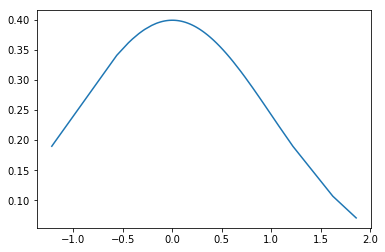

In [141]:
theta_t0 = np.sort(theta_t[:,1])
plt.plot(theta_t0, norm.pdf(theta_t0))

In [ ]:
# def PG_distribution(x_, theta_):
#     # Y ~ PG(1, z) <=> Y = X/4 where X ~ J*(1, z/2)
#     x_ = x_.reshape(-1, d)
#     accept = False
#     omega_vect = np.zeros(x_.shape[0])
#     for i in range(x_.shape[0]):
#         z = x_[i].T.dot(theta_)
#         print('x_i', x_[i])
#         ite=0
        
#         #while not accept:
#             # first step
#         sample = compute_X_from_g(x_[i], z)
#         #print('sample',sample)

#         #second step
#          # U ~ Unif(0, c_g_z)
#         u = np.random.uniform(low=0, high= compute_c_g(sample, z))
#         print('u',u)

#         # third step
#             #if (num % 2 == 0): #number is even 
#             #else: #number is odd 
#         Sn=0
#         for n in range(50):
#         #while 
#             Sn += (-1)**n * compute_a_n(sample, n)
#             print('Sn',Sn)
#             if (u <= Sn and n%2 !=0):
#                 omega_vect[i] = sample/4
#                 print(sample/4)
#                 break
#             #n +=1

#     print(omega_vect.shape)
#     return omega_vect

In [ ]:
# def pigauss(mu, lamb, born=0.64):
#     part1 = norm.cdf( np.sqrt(lamb/born) * ((born/mu) - 1.) )
#     part2 = np.exp(2*lamb/mu) * norm.cdf(- np.sqrt(lamb/born) * ((born/mu) + 1.) )
#     cdf = part1 + part2
#     return cdf
# cdf = np.zeros(10)
# j=0
# for i in np.linspace(0,5,10):
#     cdf[j] = pigauss(1,1, i)
#     j+=1
# plt.plot(cdf)